Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from xgboost import XGBClassifier

In [2]:
# Read in data as a .tsv
alexa = pd.read_csv(r'C:\Users\Christian\Documents\Kaggle Projects\amazon_alexa.tsv', delimiter='\t')

Exploratory Analysis

In [3]:
# Look at the distribution of rating scores
alexa.groupby('rating').describe()

feedback                                   
          count mean  std  min  25%  50%  75%  max
rating                                            
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

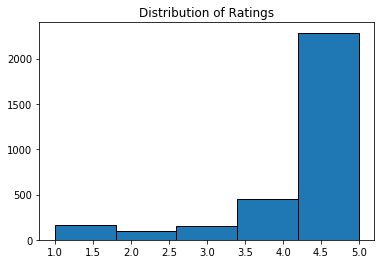

In [4]:
# Create histogram of the distribution of ratings
plt.clf()
plt.hist(alexa['rating'], bins=5, ec='black')
plt.title('Distribution of Ratings')
plt.show()

In [5]:
# Look at the distribution of feedback scores
alexa.groupby('feedback').describe()

rating                                             
           count      mean       std  min  25%  50%  75%  max
feedback                                                     
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0

So we can gather that the feedback score is simply whether the ratings are <=2 or >2

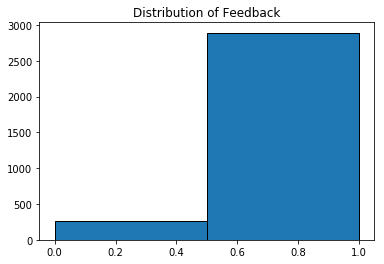

In [6]:
# Create histogram of the distribution of feedback
plt.clf()
plt.hist(alexa['feedback'], bins=2, ec='black')
plt.title('Distribution of Feedback')
plt.show()

In [7]:
# Create a variable that is the character length of each review
alexa['length'] = alexa['verified_reviews'].apply(len)

In [8]:
# Check what the length of the first review is
alexa['length'][0]

13

In [9]:
# Double check to see that it is correct
alexa['verified_reviews'][0]

'Love my Echo!'

Huzzah! It seems to be working.

<Figure size 432x288 with 0 Axes>

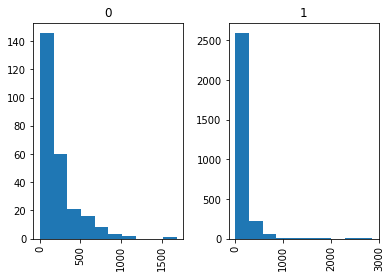

In [10]:
# Look at the distribution of length per reveiw by the feedback
plt.clf()
alexa.hist(column='length', by='feedback')
plt.show()

In [11]:
by_variation = alexa.groupby('variation').mean()[['rating']]
by_variation = by_variation.sort_values(by='rating')

<Figure size 432x288 with 0 Axes>

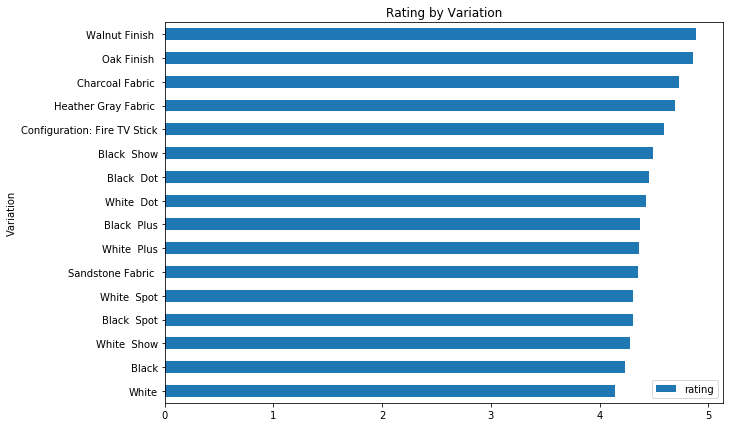

In [12]:
plt.clf()
by_variation.plot.barh(figsize=(10,7))
plt.title('Rating by Variation')
plt.ylabel('Variation')
plt.show()

It appears as though all of the reviews are positive with a very slight variation between products

Going to try to predict the feedback score of reviews using XGBoost

In [13]:
corpus=[]
ps=PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

for i in range(0,len(alexa['verified_reviews'])):
    # Keep only strings that begin with a alphabetic character
    review = re.sub('[^a-zA-Z]', ' ', alexa['verified_reviews'][i] )
    # Make review lowercase, and then split the review into individual tokens
    review = review.lower().split()
    # Porter stem the tokens of the review, while removing the stopwords
    review = [ps.stem(word) for word in review if word not in stopwords]
    # Combine the tokens into a single string
    review = ' '.join(review)
    # Append that string to the corpus
    corpus.append(review)

In [19]:
# Initialize a CountVectorizor using only the top 1500 terms, and using a mix of unigrams and bigrams
vec = CountVectorizer(max_features=1500)

In [20]:
# Creating the predictor and response variables X and y
X = vec.fit_transform(corpus).toarray()
y = alexa['feedback'].values

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

In [21]:
# Initialize an XGBoost classifier
xgb = XGBClassifier()

# Fit that classifier onto the training data
xgb.fit(X_train, y_train)

# Using the trained model, predict on the predictor test data
y_pred = xgb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
# Print the confusion matrix to check the results
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 13  54]
 [  0 721]]


Assuming that a Positive Value corresponds to a Feedback score of 1:

In [39]:
Accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
Recall = cm[1][1]/(sum(cm[1]))
Precision = cm[1][1]/(cm[1][1]+cm[0][1])

In [42]:
print('Accuracy: {}'.format(Accuracy.round(2)))
print('Recall: {}'.format(Recall))
print('Precision: {}'.format(Precision.round(2)))

Accuracy: 0.93
Recall: 1.0
Precision: 0.93


Compare Accuracy versus a Benchmark model that would predict every review to have a Feedback Score of 1

In [43]:
Benchmark_Accuracy = cm[1][1]/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Benchmark Accuracy: {}'.format(Benchmark_Accuracy.round(2)))

Benchmark Accuracy: 0.91


In [45]:
alexa['reversed_feedback'] = alexa['feedback']
for i in range(0, len(alexa['reversed_feedback'])):
    if alexa['reversed_feedback'][i] == 0:
        alexa['reversed_feedback'][i] = 1
    else: 
        alexa['reversed_feedback'][i] = 0
        
# Creating the predictor and response variables X and y
X = vec.fit_transform(corpus).toarray()
y = alexa['reversed_feedback'].values

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
